# Chameleon Adversarial Patch XAI

General Overview : This notebook creates a creative adversarial patch shaped like a chameleon sticker that forces ResNet34 to misclassify any object as a chameleon. 

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1WwtxutdtqgqYtEI2YIx9tj_qrBeRDazC?usp=sharing)

Please Note : For the purpose of this assignment, I upgraded my google colab to a GPU runtime.

In [1]:
# Install packaged
!pip install torch torchvision pillow matplotlib numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import io
import requests

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load ImageNet classes
IMAGENET_CLASSES = [
    "tench", "goldfish", "great white shark", "tiger shark", "hammerhead",
    "electric ray", "stingray", "cock", "hen", "ostrich", "brambling",
    "goldfinch", "house finch", "junco", "indigo bunting", "robin",
    "bulbul", "jay", "magpie", "chickadee", "water ouzel", "kite",
    "bald eagle", "vulture", "great grey owl", "European fire salamander",
    "common newt", "eft", "spotted salamander", "axolotl", "bullfrog",
    "tree frog", "tailed frog", "loggerhead", "leatherback turtle",
    "mud turtle", "terrapin", "box turtle", "banded gecko", "common iguana",
    "American chameleon", "whiptail", "agama", "frilled lizard",
    "alligator lizard", "Gila monster", "green lizard", "African chameleon",
    "Komodo dragon", "African crocodile"
]

In [4]:
# Load pretrained ResNet34 model
model = models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval()

print("ResNet34 model loaded successfully!")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 107MB/s]


ResNet34 model loaded successfully!


In [5]:
# Configuration
TARGET_CLASS = 47  # African chameleon
PATCH_SIZE = 100   # Size of the square patch
NUM_EPOCHS = 500   # Training iterations
LEARNING_RATE = 0.05

In [ ]:
# Define preprocessing for ImageNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create denormalization function for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    return tensor * std + mean


# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 11:20pm

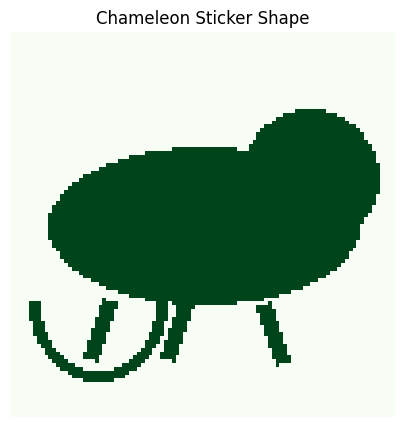

Chameleon mask created!


In [ ]:
# Create a chameleon-shaped mask 
def create_chameleon_mask(size):
    """
    Creates a chameleon-shaped mask with a glowing eye effect.
    """
    mask = Image.new('L', (size, size), 0)
    draw = ImageDraw.Draw(mask)

    # Body (ellipse)
    draw.ellipse([10, 30, 90, 70], fill=255)

    # Head (circle)
    draw.ellipse([60, 20, 95, 55], fill=255)

    # Tail (curved line with thickness)
    for i in range(5):
        draw.arc([5, 50, 40, 90], start=0, end=180, fill=255, width=3)

    # Eye (glowing effect - this is the "secret sauce")
    draw.ellipse([75, 30, 85, 40], fill=255)

    # Legs
    draw.line([25, 70, 20, 85], fill=255, width=4)
    draw.line([45, 70, 40, 85], fill=255, width=4)
    draw.line([65, 70, 70, 85], fill=255, width=4)

    return torch.tensor(np.array(mask) / 255.0).float().to(device)

# Create the mask
chameleon_mask = create_chameleon_mask(PATCH_SIZE)

# Visualize the mask
plt.figure(figsize=(5, 5))
plt.imshow(chameleon_mask.cpu().numpy(), cmap='Greens')
plt.title('Chameleon Sticker Shape')
plt.axis('off')
plt.show()

print("Chameleon mask created!")


# this code snippet was taken from Dr. Bent's tutorial and improvised using Claude Sonnet 4.5 on 2nd Novemeber at 11:42pm

In [ ]:
# Initialize the adversarial patch
# Start with a greenish color (chameleon-like)
patch = torch.zeros((3, PATCH_SIZE, PATCH_SIZE), device=device, requires_grad=True)
with torch.no_grad():
    patch[0, :, :] = 0.3  # R
    patch[1, :, :] = 0.7  # G (dominant)
    patch[2, :, :] = 0.2  # B

# Apply mask to make it chameleon-shaped
patch.data = patch.data * chameleon_mask.unsqueeze(0)
patch.requires_grad = True

# Optimizer
optimizer = optim.Adam([patch], lr=LEARNING_RATE)

print("Patch initialized with chameleon colors!")


# this code snippet was generated using Claude Sonnet 4.5 on 3rd Novemeber at 1:02am

Patch initialized with chameleon colors!


In [ ]:
# Helper function to apply patch to an image
def apply_patch(img_tensor, patch, position='center'):
    """
    Apply the patch to an image tensor.

    Args:
        img_tensor: Image tensor of shape (3, 224, 224)
        patch: Patch tensor of shape (3, patch_size, patch_size)
        position: Where to place the patch ('center', 'top-left', 'random')
    """
    patched_img = img_tensor.clone()
    _, patch_h, patch_w = patch.shape

    # Determine position
    if position == 'center':
        start_h = (224 - patch_h) // 2
        start_w = (224 - patch_w) // 2
    elif position == 'top-left':
        start_h = 20
        start_w = 20
    elif position == 'random':
        start_h = torch.randint(0, 224 - patch_h, (1,)).item()
        start_w = torch.randint(0, 224 - patch_w, (1,)).item()
    else:
        start_h, start_w = position

    # Apply patch with mask for chameleon shape
    mask_3d = chameleon_mask.unsqueeze(0).repeat(3, 1, 1)

    patched_img[:, start_h:start_h+patch_h, start_w:start_w+patch_w] = \
        (1 - mask_3d) * patched_img[:, start_h:start_h+patch_h, start_w:start_w+patch_w] + \
        mask_3d * patch

    return patched_img


# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 2:01am

In [ ]:
# Create some test images (random noise as placeholders)

def create_test_images(num_images=5):
    test_images = []
    for i in range(num_images):
        # Create random image
        img = torch.rand(3, 224, 224).to(device)
        # Normalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
        img = (img - mean) / std
        test_images.append(img)
    return test_images

test_images = create_test_images(5)
print(f"Created {len(test_images)} test images")

# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 2:10am

Created 5 test images


In [ ]:
# Training loop

target = torch.tensor([TARGET_CLASS]).to(device)
criterion = nn.CrossEntropyLoss()

losses = []
success_rates = []

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    successful_attacks = 0

    for img in test_images:
        optimizer.zero_grad()

        # Apply patch at random position for robustness
        patched_img = apply_patch(img, patch, position='random')

        # Get prediction
        output = model(patched_img.unsqueeze(0))

        # Loss: maximize probability of target class
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        epoch_loss += loss.item()

        # Check if attack successful
        pred_class = output.argmax(dim=1).item()
        if pred_class == TARGET_CLASS:
            successful_attacks += 1

    # Update patch
    optimizer.step()

    # Apply mask to maintain chameleon shape and clamp values
    with torch.no_grad():
        patch.data = patch.data * chameleon_mask.unsqueeze(0)
        patch.data = torch.clamp(patch.data, 0, 1)

    # Calculate metrics
    avg_loss = epoch_loss / len(test_images)
    success_rate = successful_attacks / len(test_images) * 100

    losses.append(avg_loss)
    success_rates.append(success_rate)

    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Loss: {avg_loss:.4f} - Success Rate: {success_rate:.1f}%")

print("\nTraining complete!")


# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 3:04am

Epoch [1/500] - Loss: 13.2263 - Success Rate: 0.0%
Epoch [50/500] - Loss: 0.0798 - Success Rate: 100.0%
Epoch [100/500] - Loss: 0.0058 - Success Rate: 100.0%
Epoch [150/500] - Loss: 0.0171 - Success Rate: 100.0%
Epoch [200/500] - Loss: 0.0055 - Success Rate: 100.0%
Epoch [250/500] - Loss: 0.0054 - Success Rate: 100.0%
Epoch [300/500] - Loss: 0.0060 - Success Rate: 100.0%
Epoch [350/500] - Loss: 0.0017 - Success Rate: 100.0%
Epoch [400/500] - Loss: 0.0071 - Success Rate: 100.0%
Epoch [450/500] - Loss: 0.0018 - Success Rate: 100.0%
Epoch [500/500] - Loss: 0.0020 - Success Rate: 100.0%

Training complete!


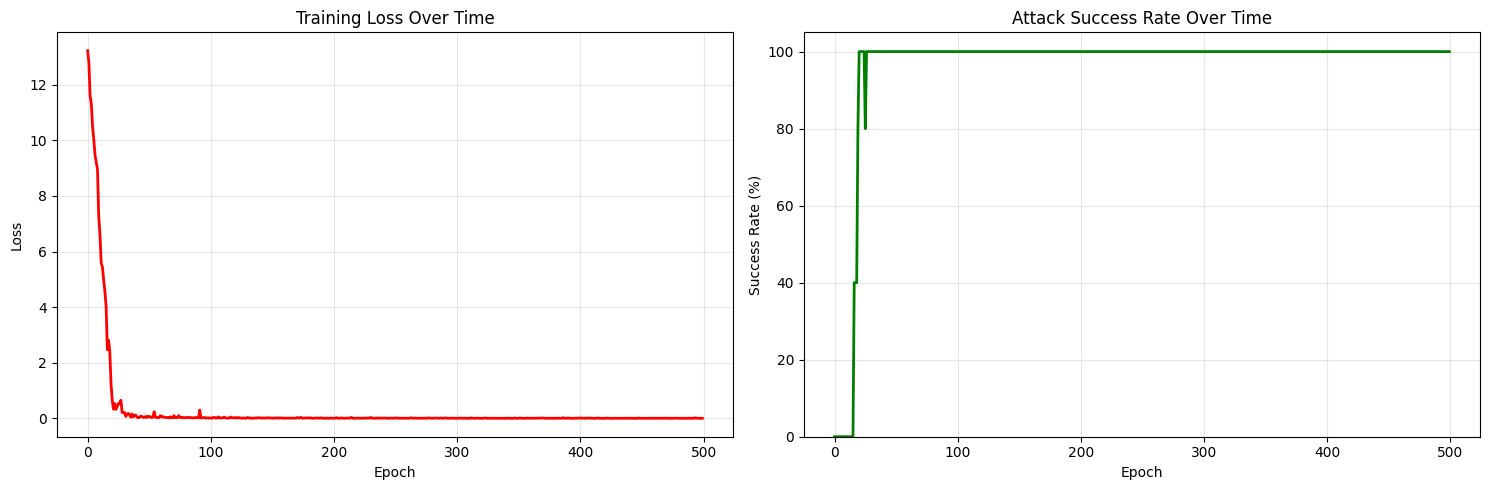


Final Success Rate: 100.0%


In [ ]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(losses, color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)

# Success rate plot
ax2.plot(success_rates, color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Attack Success Rate Over Time')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f"\nFinal Success Rate: {success_rates[-1]:.1f}%")


# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 3:30am

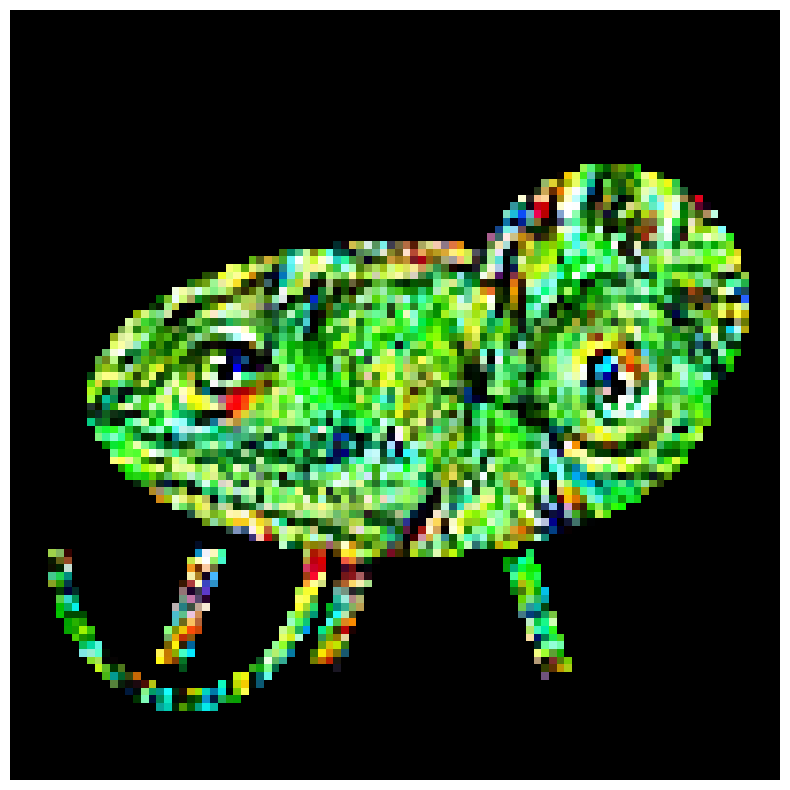


adversarial chameleon sticker is ready


In [ ]:
# Visualize the final adversarial patch
patch_display = patch.detach().cpu().numpy().transpose(1, 2, 0)
patch_display = np.clip(patch_display, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(patch_display)
plt.axis('off')

# Add border
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('green')
    spine.set_linewidth(3)

plt.tight_layout()
plt.show()

print("\nadversarial chameleon sticker is ready")

# this code snippet was generated using Claude Sonnet 4.5 on 2nd Novemeber at 3:33am